Starting code for a MLP classifier for cardiac arrest for tabular data - Josh

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics   



In [4]:
df = pd.read_csv("1000_nonca_574_ca.csv")
# df = pd.read_csv("added_feature_1000_nca_574_ca.csv")

In [5]:
df.head()

,Unnamed: 0,SUBJECT_ID,HADM_ID,220045,220210,220277,224167,227243,gender,cardiac,ADMITTIME,DISCHTIME,DOB,age
0,9633,79229,145474,67.0,21.0,96.0,NaN,NaN,M,0,2153/2/11 22:20,2153/2/14 18:00,2074/6/3 0:00,78
1,498,32511,102385,70.0,20.0,96.0,NaN,NaN,M,0,2147/9/22 6:12,2147/10/2 16:30,2060/10/23 0:00,86
2,11180,51767,152759,83.0,15.5,99.0,NaN,NaN,M,0,2191/6/16 11:45,2191/6/21 14:30,2132/7/18 0:00,58
3,8170,46755,138568,78.0,15.0,96.0,NaN,NaN,F,0,2183/3/8 10:24,2183/3/13 15:13,2122/10/27 0:00,60
4,13220,85417,162413,64.0,20.0,96.0,NaN,NaN,M,0,2183/9/8 0:19,2183/10/3 16:50,2131/11/1 0:00,51


In [6]:
df.drop(['ADMITTIME', 'DISCHTIME', 'DOB'], axis=1, inplace=True)
df.head()

,Unnamed: 0,SUBJECT_ID,HADM_ID,220045,220210,220277,224167,227243,gender,cardiac,age
0,9633,79229,145474,67.0,21.0,96.0,NaN,NaN,M,0,78
1,498,32511,102385,70.0,20.0,96.0,NaN,NaN,M,0,86
2,11180,51767,152759,83.0,15.5,99.0,NaN,NaN,M,0,58
3,8170,46755,138568,78.0,15.0,96.0,NaN,NaN,F,0,60
4,13220,85417,162413,64.0,20.0,96.0,NaN,NaN,M,0,51


In [7]:
# df = df[['SUBJECT_ID', 'HADM_ID', '220045', '220210', '220277', '224167', '227243','223770','223769','226253','220046','220047', 'gender','age','cardiac']]
df = df[['SUBJECT_ID', 'HADM_ID', '220045', '220210', '220277', '224167', '227243', 'gender','age','cardiac']]
df.head()

,SUBJECT_ID,HADM_ID,220045,220210,220277,224167,227243,gender,age,cardiac
0,79229,145474,67.0,21.0,96.0,NaN,NaN,M,78,0
1,32511,102385,70.0,20.0,96.0,NaN,NaN,M,86,0
2,51767,152759,83.0,15.5,99.0,NaN,NaN,M,58,0
3,46755,138568,78.0,15.0,96.0,NaN,NaN,F,60,0
4,85417,162413,64.0,20.0,96.0,NaN,NaN,M,51,0


In [8]:
# pd.get_dummies(df['gender'])
cleanup_nums = {"gender":     {"F": 0, "M": 1}}
df.replace(cleanup_nums, inplace=True)
df.head()

,SUBJECT_ID,HADM_ID,220045,220210,220277,224167,227243,gender,age,cardiac
0,79229,145474,67.0,21.0,96.0,NaN,NaN,1,78,0
1,32511,102385,70.0,20.0,96.0,NaN,NaN,1,86,0
2,51767,152759,83.0,15.5,99.0,NaN,NaN,1,58,0
3,46755,138568,78.0,15.0,96.0,NaN,NaN,0,60,0
4,85417,162413,64.0,20.0,96.0,NaN,NaN,1,51,0


In [9]:
df.drop(['SUBJECT_ID','HADM_ID','224167','227243'], axis=1, inplace=True)
df.head(2)

,220045,220210,220277,gender,age,cardiac
0,67.0,21.0,96.0,1,78,0
1,70.0,20.0,96.0,1,86,0


In [10]:
df=df.fillna(df.mean())


In [11]:
# TESTINGTESTINGTESTINGTESTINGTESTINGTESTINGTESTINGTESTING
# df.drop(['223770','223769','226253','220046','220047'], axis=1, inplace=True)
# df.head(2)

Look for a potential class imbalance here

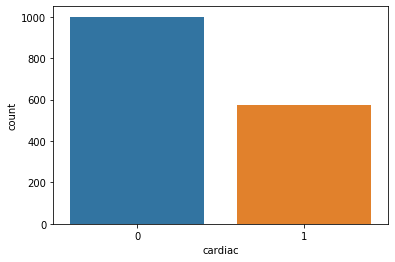

In [12]:
sns.countplot(x = 'cardiac', data=df)

In [13]:
# Class count
count_class_0, count_class_1 = df.cardiac.value_counts()
# Divide by class
df_class_0 = df[df['cardiac'] == 0]
df_class_1 = df[df['cardiac'] == 1]

Random under-sampling:
1    574
0    574
Name: cardiac, dtype: int64


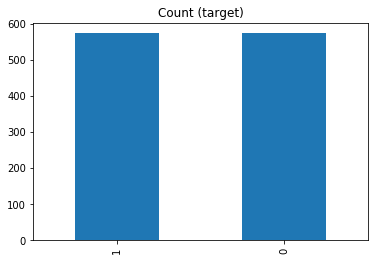

In [14]:
# Random under-sampling
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.cardiac.value_counts())

df_test_under.cardiac.value_counts().plot(kind='bar', title='Count (target)');

In [15]:
df_test_under.head()

,220045,220210,220277,gender,age,cardiac
81,71.0,18.0,95.0,0,77,0
11,70.0,23.0,94.0,0,77,0
739,74.0,23.0,98.0,0,72,0
727,76.0,15.5,99.0,0,28,0
884,96.0,19.0,100.0,0,57,0


In [16]:
df.head()

,220045,220210,220277,gender,age,cardiac
0,67.0,21.0,96.0,1,78,0
1,70.0,20.0,96.0,1,86,0
2,83.0,15.5,99.0,1,58,0
3,78.0,15.0,96.0,0,60,0
4,64.0,20.0,96.0,1,51,0


In [17]:
df_test_under.to_csv('balanced_dataset.csv')

In [18]:
df_test_under=df_test_under.sort_index()

In [19]:
df=df_test_under

Encode Output Class (remaps the labels to start from 0) (not sure if needed)

In [20]:
# df['Cardiac_arrest'] = df['Cardiac_arrest'].astype('category')
# encode_map = {
#     'Abnormal': 1,
#     'Normal': 0
# }

# df['Cardiac_arrest'].replace(encode_map, inplace=True)

Create Input and Output Data

In [21]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [22]:
X.head(2)

,220045,220210,220277,gender,age
0,67.0,21.0,96.0,1,78
1,70.0,20.0,96.0,1,86


In [23]:
y

0       0
1       0
2       0
4       0
7       0
       ..
1569    1
1570    1
1571    1
1572    1
1573    1
Name: cardiac, Length: 1148, dtype: int64

In [24]:
X=X.fillna(X.mean())
y=y.fillna(y.mean())

In [25]:
X

,220045,220210,220277,gender,age
0,67.0,21.0,96.0,1,78
1,70.0,20.0,96.0,1,86
2,83.0,15.5,99.0,1,58
4,64.0,20.0,96.0,1,51
7,63.0,16.0,98.0,0,89
...,...,...,...,...,...
1569,82.0,21.0,98.0,0,46
1570,65.5,17.0,94.0,1,86
1571,76.0,21.0,98.0,1,69
1572,65.0,18.0,97.0,0,59


In [26]:
# from sklearn import preprocessing

# x = X.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# X2 = pd.DataFrame(x_scaled)

In [27]:
# # DOING PCA
# import pandas as pd
# import numpy as np
# from sklearn.decomposition import PCA

# # df134124 = pd.DataFrame(data=np.random.normal(0, 1, (20, 10)))

# num_components=5

# pca = PCA(n_components=num_components)
# pca.fit(X)
# pca.components_ 
# X2=pd.DataFrame(pca.transform(X), columns=['PCA%i' % i for i in range(num_components)], index=df.index)


In [28]:
# print(pca.explained_variance_)


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=10)

In [30]:
X_train.head(5)

,220045,220210,220277,gender,age
1350,72.0,33.5,96.0,1,82
1045,69.0,21.0,100.0,0,52
378,87.5,16.0,98.0,0,85
897,83.0,17.0,97.0,1,59
1161,63.0,17.0,100.0,1,72


In [31]:
y_train.head(5)

1350    1
1045    1
378     0
897     0
1161    1
Name: cardiac, dtype: int64

In [32]:
X_train.shape

(975, 5)

In [33]:
X_test.shape

(173, 5)

In [34]:
y_test.shape

(173,)

In [35]:
y_train.shape

(975,)

Standardize Input Values

In [36]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

Model HyperParameters

In [37]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

Define a Dataloader

In [38]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train.values))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

Initialize a dataloader with a batch_size = 1 for our test dataloader.

In [105]:
from torch.utils.data.sampler import SubsetRandomSampler

validation_split = 0.15
dataset_len = len(train_data)
indices = list(range(dataset_len))

# Randomly splitting indices:
val_len = int(np.floor(validation_split * dataset_len))
validation_idx = np.random.choice(indices, size=val_len, replace=False)
train_idx = list(set(indices) - set(validation_idx))

# Contiguous split
# train_idx, validation_idx = indices[split:], indices[:split]

## Defining the samplers for each phase based on the random indices:
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)

train_loader = DataLoader(train_data, sampler=train_sampler)
validation_loader = DataLoader(train_data, sampler=validation_sampler)
data_loaders = {"train": train_loader, "val": validation_loader}
data_lengths = {"train": len(train_idx), "val": val_len}

In [106]:
print(validation_idx)

[938 673 518 829 215 169  94 641 467 177 452 849 558 333 423 866 885 450
 484 749 246 930  39 859  99 576  76  75 581 166 732 858  82 365 487 748
 672 144 851 639  18 559 674 796  29 575 691 187 165 182 278 455  28 129
 171   4 426 449  49 703 457 719 739  17 229 478 591 102 402 548 776 293
  87 716 780 848 160 746 410  52 708 232  89 519 431 609 546 261  27  90
 651 224 503 662  69 574 789 660 442 271 294 913 176 692   7 415 195 499
 735 521 606 958 730 359 823 645 101 184 617 886  78 473 287 928 407 180
 931 219 146 620 528  56 969 404 323 729 888 613 804 475 893 352 159 870
 601 241]


In [107]:
# train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

The input to our first nn.Linear layer would be 16 Since the number of input features in our dataset is 16

In [145]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 5.
        self.layer_1 = nn.Linear(5, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_3 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

Check for GPU

In [109]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Initialize optimizer and loss function

In [123]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=5, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)


In [124]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

Train and Validate the model

In [153]:
# Training with Validation
n_epochs = 5 # for demonstration purposes, normally would run around 50 epochs
net = model

for epoch in range(n_epochs):
    print('Epoch {}/{}'.format(epoch, n_epochs - 1))
    print('-' * 10)
    epoch_loss = 0
    epoch_acc = 0
    
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        print("phase: ", phase)
        if phase == 'train':
#             optimizer = scheduler(optimizer, epoch)
            net.train(True)  # Set model to training mode
        else:
            net.train(False)  # Set model to evaluate mode

        running_loss = 0.0

        # Iterate over data.
        for X_batch, y_batch in data_loaders[phase]:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    #         print('X_batch: ',X_batch.shape)
    #         if (X_batch.shape != torch.Size([64, 5])):
    #             continue

            optimizer.zero_grad()

            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch.unsqueeze(1))
            acc = binary_acc(y_pred, y_batch.unsqueeze(1))
            
            
            if phase == 'train':
                loss.backward()
                optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
        print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    
#         epoch_loss = running_loss / data_lengths[phase]
#         print('{} Loss: {:.4f}'.format(phase, epoch_loss))

Epoch 0/4
----------
phase:  train
Epoch 005: | Loss: 0.32007 | Acc: 84.198
phase:  val
Epoch 005: | Loss: 0.65580 | Acc: 94.934
Epoch 1/4
----------
phase:  train
Epoch 005: | Loss: 0.30929 | Acc: 86.007
phase:  val
Epoch 005: | Loss: 0.57173 | Acc: 95.899
Epoch 2/4
----------
phase:  train
Epoch 005: | Loss: 0.31949 | Acc: 85.404
phase:  val
Epoch 005: | Loss: 0.58177 | Acc: 95.416
Epoch 3/4
----------
phase:  train
Epoch 005: | Loss: 0.30514 | Acc: 85.283
phase:  val
Epoch 005: | Loss: 0.55762 | Acc: 95.416
Epoch 4/4
----------
phase:  train
Epoch 005: | Loss: 0.33893 | Acc: 85.283
phase:  val
Epoch 005: | Loss: 0.62353 | Acc: 95.899


Test the model

In [154]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [155]:
len(y_pred_list)
# y_test

173

In [156]:
# Calculate the confusion matrix
cf=confusion_matrix(y_test, y_pred_list)

In [157]:
tn = cf[0][0]
fp = cf[0][1]
fn = cf[1][0]
tp = cf[1][1]
sensitivity= tp/(tp+fn)
specificity = tn /(tn+fp)
print('sensitivity: ',sensitivity)
print('specificity: ',specificity)
print('ROC AUC: ',metrics.roc_auc_score(y_test, y_pred_list))

sensitivity:  0.6555555555555556
specificity:  0.5421686746987951
ROC AUC:  0.5988621151271754


In [158]:
# Print classification report with precision, recall, and F1 score
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.59      0.54      0.57        83
           1       0.61      0.66      0.63        90

    accuracy                           0.60       173
   macro avg       0.60      0.60      0.60       173
weighted avg       0.60      0.60      0.60       173

